In [1]:
library(ggplot2)
library(data.table)
theme_set(theme_bw())

In [2]:
tools = c('singlem', 'metaphlan', 'motus', 'kraken', 'sourmash', 'kaiju', 'map2b', 'metabuli')
# Tools that do not have the correct taxonomy are tested only at the domain level. eg. Kaiju has NCBI taxonomy and MAP2B uses GTDB v202, mOTUs sometimes has incompatible strings
correct_taxonomy_tools = c('singlem', 'metaphlan', 'kraken', 'sourmash', 'metabuli')

publication_names = data.table(
    tool = tools,
    publication_name = c('SingleM', 'MetaPhlAn', 'mOTUs', 'Kraken2', 'sourmash', 'Kaiju', 'MAP2B', 'Metabuli')
)
name_to_publication_name = function(names, correct_taxonomy_only=F){
    to_return = c()
    for (name in names){
        to_return = c(to_return, publication_names[tool==name]$publication_name)
    }
    if (correct_taxonomy_only){
        return(factor(to_return, levels=publication_names[tool %in% correct_taxonomy_tools]$publication_name))
    } else {
        return(factor(to_return, levels=publication_names$publication_name))
    }
}

In [3]:
# setwd('~/m/msingle/mess/124_singlem-benchmarking/3_cami2_marine/')
# base_dir = './'
# base_dir = 'full_run8/checkout/1_novel_strains/' # Directory created when run in local scratch through queuing system

In [4]:
communities = gsub('^','marine',as.character(0:9))
# communities = gsub('^','marine',as.character(6)) # debug
communities

[1] "marine0" "marine1" "marine2" "marine3" "marine4" "marine5" "marine6"
 [8] "marine7" "marine8" "marine9"

In [5]:
d1 = data.table(expand.grid(correct_taxonomy_tools, communities))
setnames(d1, c('tool', 'community'))
d1[1:3]

tool,community
<fct>,<fct>
singlem,marine0
metaphlan,marine0
kraken,marine0


In [6]:
# output_singlem/opal/GCA_022615805.1_genomic.opal_report
readit = function(tool, community){
    to_read = paste('output_',tool,sep='','/opal/',community,'.opal_report')
    # print(to_read)
    return(fread(to_read))
}
d2 = d1[, readit(tool, community), by=list(tool,community)]
d2[1:3]

tool,community,tool,rank,metric,sample,value
<fct>,<fct>,<chr>,<chr>,<chr>,<chr>,<dbl>
singlem,marine0,Gold standard,kingdom,Bray-Curtis distance,SAMPLEID,0
singlem,marine0,Gold standard,phylum,Bray-Curtis distance,SAMPLEID,0
singlem,marine0,Gold standard,class,Bray-Curtis distance,SAMPLEID,0


In [7]:
dim(d2)

[1] 9100    7

In [8]:
setnames(d2, c('tool','community','blah','rank','metric','sample','value'))
d3 = d2[blah != 'Gold standard'][,.(tool, community, rank, metric, value)]
d3[1:3]
dim(d3)

tool,community,rank,metric,value
<fct>,<fct>,<chr>,<chr>,<dbl>
singlem,marine0,kingdom,Bray-Curtis distance,0.001003460
singlem,marine0,phylum,Bray-Curtis distance,0.007422594
singlem,marine0,class,Bray-Curtis distance,0.009349926


[1] 4550    5

In [9]:
bc = d3[metric=='Bray-Curtis distance']
dim(bc)
bc[1:10]

[1] 350   5

tool,community,rank,metric,value
<fct>,<fct>,<chr>,<chr>,<dbl>
singlem,marine0,kingdom,Bray-Curtis distance,0.001003460
singlem,marine0,phylum,Bray-Curtis distance,0.007422594
singlem,marine0,class,Bray-Curtis distance,0.009349926
singlem,marine0,order,Bray-Curtis distance,0.018814001
singlem,marine0,family,Bray-Curtis distance,0.025485587
singlem,marine0,genus,Bray-Curtis distance,0.039697274
singlem,marine0,species,Bray-Curtis distance,0.149309468
metaphlan,marine0,kingdom,Bray-Curtis distance,0.008001919
metaphlan,marine0,phylum,Bray-Curtis distance,0.019410133


In [10]:
orders = c('kingdom','phylum','class','order','family','genus','species')
bc[, rank := factor(rank, levels=orders)]
bc[1:3]

tool,community,rank,metric,value
<fct>,<fct>,<fct>,<chr>,<dbl>
singlem,marine0,kingdom,Bray-Curtis distance,0.001003460
singlem,marine0,phylum,Bray-Curtis distance,0.007422594
singlem,marine0,class,Bray-Curtis distance,0.009349926


In [11]:
average_bc = bc[tool %in% correct_taxonomy_tools][, mean(value), by=list(tool)][order(V1)]
average_bc

tool,V1
<fct>,<dbl>
singlem,0.03914329
metaphlan,0.04414917
kraken,0.12923947
sourmash,0.13383459
metabuli,0.13944197


In [12]:
bcc = bc[tool %in% correct_taxonomy_tools]
bcc[, tool2 := name_to_publication_name(tool, correct_taxonomy_only=T)]

Warning message:
“`qplot()` was deprecated in ggplot2 3.4.0.”
Warning message:
“A numeric `legend.position` argument in `theme()` was deprecated in ggplot2
3.5.0.
ℹ Please use the `legend.position.inside` argument of `theme()` instead.”
Warning message:
“The `size` argument of `element_rect()` is deprecated as of ggplot2 3.4.0.
ℹ Please use the `linewidth` argument instead.”


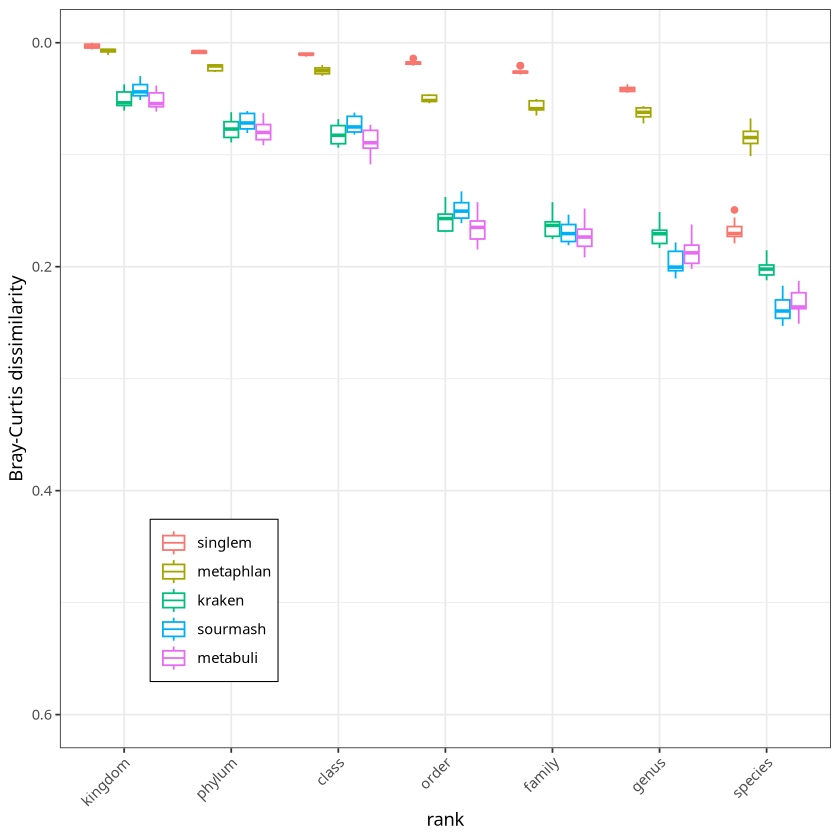

In [13]:
# Remove figure legend title, and put the legend in bottom left of plot, with a bounding box
qplot(data=bcc, rank, value, ylim=c(0.6,0), geom='boxplot', colour=tool, ylab='Bray-Curtis dissimilarity') + theme(axis.text.x = element_text(angle = 45, hjust = 1))+theme(legend.title=element_blank()) + theme(legend.position=c(0.2,0.2)) + theme(legend.background = element_rect(colour = "black", size = 0.3))

In [14]:
# How much better is singlem than the next best tool?
means = bcc[rank=='species', mean(value), by=tool][order(-V1)]
means
means[tool=='singlem', V1] - means[tool!='singlem', min(V1)]

tool,V1
<fct>,<dbl>
sourmash,0.23753515
metabuli,0.23127617
kraken,0.20172044
singlem,0.16755522
metaphlan,0.08452814


[1] 0.08302708

In [15]:
# write out bc
fwrite(d3, 'accuracy_results.csv', sep='\t')

In [16]:
d3[metric=='Bray-Curtis distance'][rank=='genus'][,.(mean(value)), by=.(tool)][order(-V1)]

tool,V1
<fct>,<dbl>
sourmash,0.19606085
metabuli,0.18742518
kraken,0.17155405
metaphlan,0.06277543
singlem,0.04135677


In [17]:
d3[metric=='F1 score'][rank=='species'][,.(mean(value)), by=.(tool)][order(-V1)]

tool,V1
<fct>,<dbl>
metaphlan,0.92575106
singlem,0.71576100
sourmash,0.53925307
kraken,0.33698593
metabuli,0.08914664


In [18]:
d3[metric=='F1 score'][rank=='genus'][,.(mean(value)), by=.(tool)][order(-V1)]

tool,V1
<fct>,<dbl>
metaphlan,0.9754939
singlem,0.8663457
kraken,0.6384775
sourmash,0.6133644
metabuli,0.1874770


In [19]:
d3[metric=='Purity'][rank=='species'][,.(mean(value)), by=.(tool)][order(-V1)]

tool,V1
<fct>,<dbl>
sourmash,0.9626887
singlem,0.9622377
metaphlan,0.9444546
kraken,0.2037769
metabuli,0.0468960


In [20]:
d3[metric=='Completeness'][rank=='species'][,.(mean(value)), by=.(tool)][order(-V1)]

tool,V1
<fct>,<dbl>
kraken,0.9939173
metabuli,0.9123367
metaphlan,0.9078069
singlem,0.5712804
sourmash,0.3758449


In [21]:
d3[metric=='Completeness'][rank=='genus'][,.(mean(value)), by=.(tool)][order(-V1)]

tool,V1
<fct>,<dbl>
kraken,0.9915413
metabuli,0.9573970
metaphlan,0.9522063
singlem,0.7688222
sourmash,0.4435420


In [22]:
# What is the reason for the lower F1 score (really completeness) of SingleM on CAMI ?

# Take marine7 as an example
# Read gold standard condensed
gs = fread('truths/marine7.condensed')[order(-coverage)]
gs[, taxonomy := gsub(';','; ',taxonomy)]
sm = fread('output_singlem/singlem/marine7.profile')[order(-coverage)]
gs[1:3]

sm_species = sm[grep('s__', taxonomy)][order(-coverage)]
sm_species[1:3]

sample,coverage,taxonomy
<chr>,<dbl>,<chr>
marine7,134.52649,Root; d__Bacteria; p__Proteobacteria; c__Gammaproteobacteria; o__Nitrococcales; f__Nitrococcaceae; g__Spiribacter; s__Spiribacter curvatus
marine7,92.06454,Root; d__Archaea; p__Thermoproteota; c__Thermoproteia; o__Sulfolobales; f__Pyrodictiaceae; g__Hyperthermus; s__Hyperthermus butylicus
marine7,75.66944,Root; d__Bacteria; p__Proteobacteria; c__Gammaproteobacteria; o__Nitrosococcales; f__Nitrosococcaceae; g__Nitrosococcus; s__Nitrosococcus halophilus


sample,coverage,taxonomy
<chr>,<dbl>,<chr>
marine7.1,111.03,Root; d__Bacteria; p__Proteobacteria; c__Gammaproteobacteria; o__Nitrococcales; f__Nitrococcaceae; g__Spiribacter; s__Spiribacter curvatus
marine7.1,73.49,Root; d__Archaea; p__Thermoproteota; c__Thermoproteia; o__Sulfolobales; f__Pyrodictiaceae; g__Hyperthermus; s__Hyperthermus butylicus
marine7.1,63.56,Root; d__Bacteria; p__Proteobacteria; c__Gammaproteobacteria; o__Nitrosococcales; f__Nitrosococcaceae; g__Nitrosococcus; s__Nitrosococcus halophilus


Warning message:
“Removed 57 rows containing missing values or values outside the scale range
(`geom_point()`).”


Warning message:
“Removed 63 rows containing missing values or values outside the scale range
(`geom_point()`).”


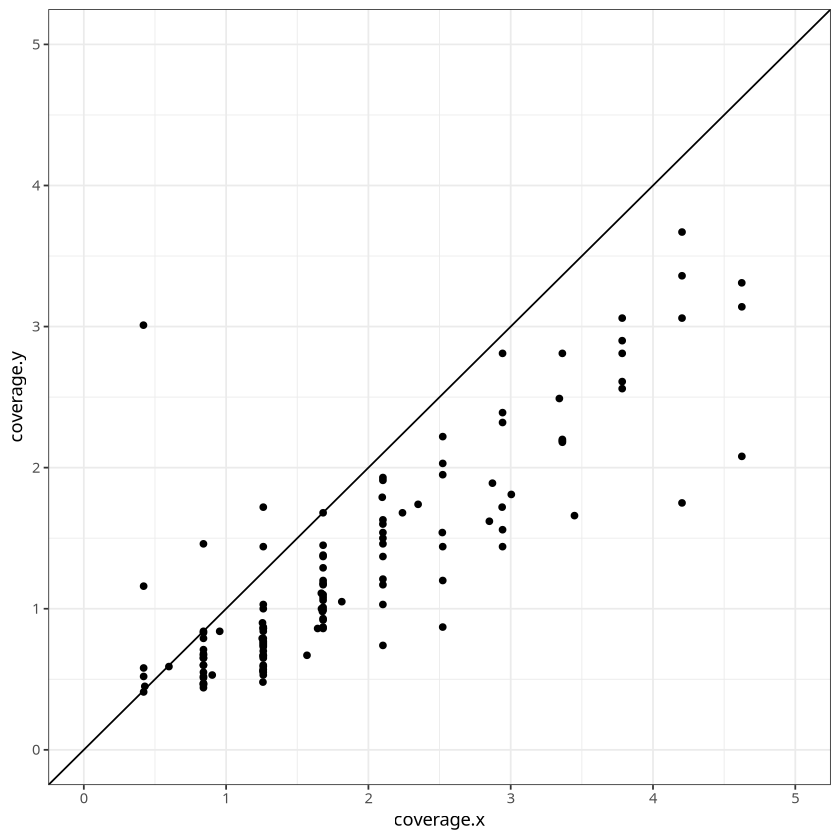

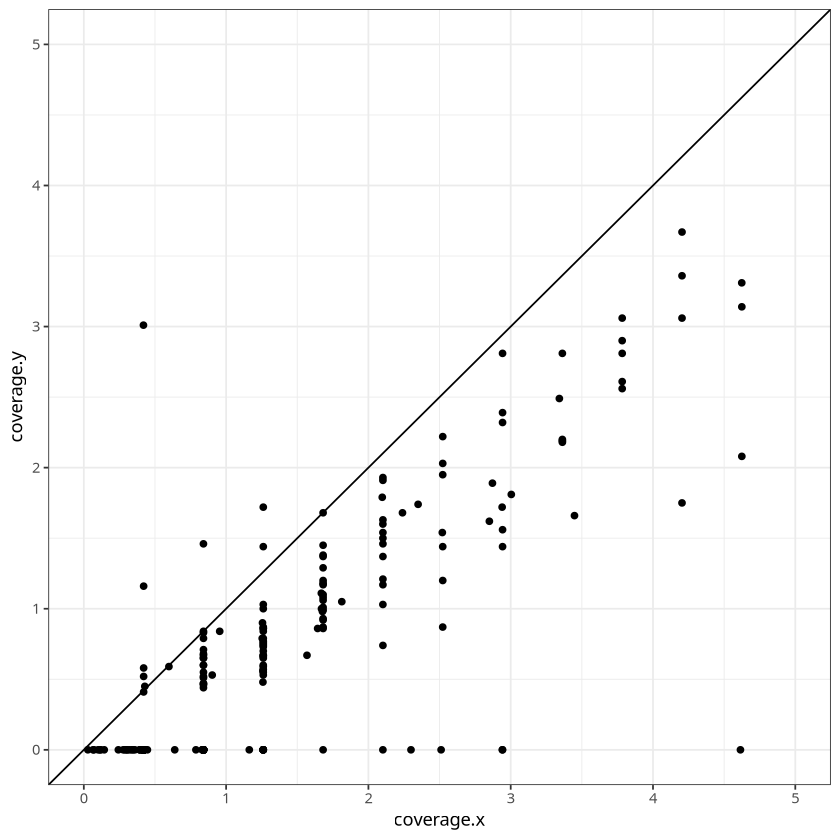

In [23]:
# So just a coverage thing?
qplot(data=merge(gs, sm_species, by='taxonomy'), coverage.x, coverage.y)+geom_abline(intercept=0, slope=1)+xlim(c(0,5))+ylim(c(0,5))
m = merge(gs, sm_species, by='taxonomy', all.x=T)
m[is.na(coverage.y), coverage.y := 0]
qplot(data=m, coverage.x, coverage.y)+geom_abline(intercept=0, slope=1)+xlim(c(0,5))+ylim(c(0,5))

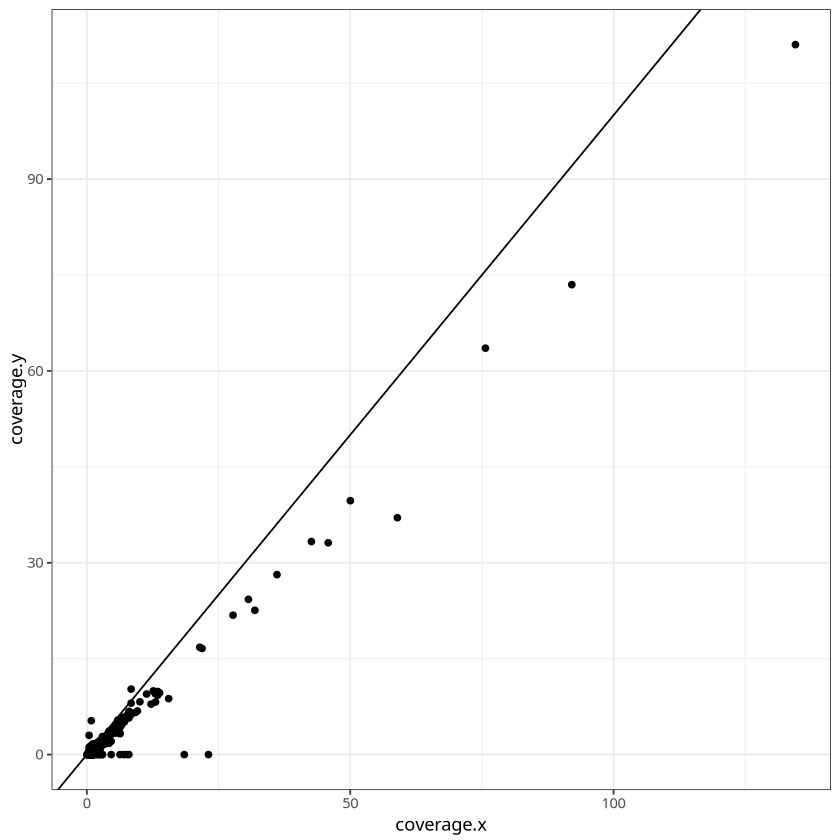

In [24]:
qplot(data=m, coverage.x, coverage.y)+geom_abline(intercept=0, slope=1)

In [25]:
# What length are the reads?
# $ fastq_count.sh marine7.1.fq.gz
# marine7.1.fq.gz 16645651        2496847650
2496847650/16645651

[1] 150

# Write overall results for supp data

In [26]:
d3w = d3[tool!='Gold standard'][,.(value=mean(value)), by=list(tool,metric,rank)]
d3w[, rank := factor(rank, levels=c('species','genus','family','order','class','phylum','kingdom'))]
d3w[, tool2 := name_to_publication_name(tool, correct_taxonomy_only = T)]
# dcast(d3w, rank+tool2~metric, value.var='value')
fwrite(x=dcast(d3w, rank+tool2~metric, value.var='value'), file='supp_data1.csv')